In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
#constantes
Kb = 8.6173324e-5 #ev - cibstabte de boltzmann

SIZE = 4 # Ordem da matriz
TEMPERATURAS = [i for i in range(15,600,40)] # Range de temperaturas
#TEMPERATURAS = [30,40,50]

E_A = 0 # Energia on site "A"
E_B = 0 # Energia on site "B"
E_AA = -0.02 # Energia interacao entre "A" e "A"
E_BB = -0.02 # Energia interacao entre "B" e "B"
E_AB = -0.01 # Energia interacao entre "A" e "B"

N_A_range = np.array([n for n in np.arange(0,(SIZE*SIZE)+1,1)]) # Range da quantidade de "A"
N_B_range = N_A_range[::-1] # Range da quantidade de "B" considerando "A"
N_A_percentage = N_A_range/(SIZE*SIZE) # Concentracao

In [3]:
def possible_matrices(N_a, N_b):
    """
    N_a: numero de elementos "A"
    N_b: numero de elementos "B"
    """

    global SIZE
    
    # Check sum
    if N_a + N_b != SIZE * SIZE:
        raise ValueError("The total number of 'A's and 'B's should match the size of the matrix.")
    
    if N_a == 0:
        return np.full((1, SIZE, SIZE), 'B', dtype='<U1')
    
    # Gerar combinacoes
    indices_A = np.array(list(itertools.combinations(range(SIZE*SIZE), N_a)))
    
    # Gerar matrizes full "B"
    matrices = np.full((len(indices_A), SIZE, SIZE), 'B', dtype='<U1')
    
    # Indices possiveis "A"
    for i, indices in enumerate(indices_A):
        indices = np.unravel_index(indices, (SIZE, SIZE))
        matrices[i][indices] = 'A'
    
    return matrices

In [4]:
def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual se quer saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    
    vizinhos = {}
    linhas, colunas = matriz.shape

    for i, j in itertools.product(range(linhas), range(colunas)):
        vizinhos[(i, j)] = []

        # Vizinhos à direita e abaixo
        det_vizinhos = lambda x, y: vizinhos[(i, j)].append(matriz[x, y])
        if j < colunas - 1: det_vizinhos(i, j + 1)
        if i < linhas - 1: det_vizinhos(i + 1, j)

        # Vizinhos nas bordas
        if j == 0: det_vizinhos(i, colunas - 1)
        if j == colunas - 1: det_vizinhos(i, 0)
        if i == 0: det_vizinhos(linhas - 1, j)
        if i == linhas - 1: det_vizinhos(0, j)

    return vizinhos

In [5]:
def energia_total(matriz, N_a, N_b):
    """ Esta função calcula a energia a energia total da celula.
    
    Args:
        matriz: configuração da célula.
        N_a: numero de particulas "A"
        N_b: numero de particulas "B"
        
    Return:
        energia_célula: energia total da configuração da célula.
    """

    global E_A, E_B, E_AA, E_BB, E_AB

    vizinhos_dict = determinar_vizinhos(matriz)
    energias_vizinhos = np.array([])

    E_on_site = N_a * E_A + N_b * E_B

    for coordenada, vizinhos in vizinhos_dict.items():
        i, j = coordenada
        elemento = matriz[i, j]
        vizinhos = np.array(vizinhos)

        # Energia entre o elemento e seus vizinhos
        energia_elemento_vizinhos = np.where(elemento != vizinhos, E_AB, 
                                              np.where(elemento == 'A', E_AA, E_BB))
        energias_vizinhos = np.concatenate((energias_vizinhos, energia_elemento_vizinhos))

    energia_célula = np.sum(energias_vizinhos) + E_on_site
    return energia_célula

In [6]:
def helmholtz(energia_matrix_list, temperatura):
    """Essa função calcula o valor da energia de helmholtz com base na função de partição.
    
    Args:
        
        energia_matrix_list: lista com a energia de cada configuração da celula.
        temperatura: temperatura da celula.
        
    Return:
    
        F: energia de helmholtz da concentracao
    """

    global Kb

    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energia_matrix_list:
        Z += np.exp(-beta * energia)

    F = -(Kb * temperatura) * np.log(Z)
    
    return F


In [7]:
def pappu(T, sigma):
    """ Essa função calcula o campo medio.

    Args:
        T: Temperatura em K
        sigma: Concentracao atual de A em relacao ao total.

    Return:
        F: Energia de Helmholtz dada a aproximacao de campo medio.

    """

    global Kb, E_AA, E_AB, E_BB

    if (sigma == 0) or (sigma == 1):
        return 0

    xi = 4/(Kb*T) * (E_AB - (E_AA + E_BB)/2)
    first = sigma*np.log(sigma)
    second = (1-sigma)*np.log(1-sigma)
    third = xi*sigma*(1-sigma)

    F = Kb*T * (first + second + third)


    return F

In [8]:
def determinar_ensemble_canonico(temperaturas):
    """ Essa funcao determina o DataFrame para o plot da energia de helmholtz em relacao a concentracao com variacao de temperatura, baseado no ensemble canonico.

    Args:
        temperaturas: lista de temperaturas a serem utilizadas.

    Return:
        data: DataFrame contendo as concentracoes discretas, razao de concentracao,energia de hemholtz, temperaturas e a quantidade de particulas "A".

    """

    global SIZE, N_A_range, N_B_range, N_A_percentage, E_AA, E_BB, E_AB

    energia_matrix_list = []
    energia_helmholtz_list = []
    temperaturas_list = []

    for T in tqdm(temperaturas,desc= "Temperature"):
        for N_a, N_b in tqdm(zip(N_A_range,N_B_range), desc= "Concentration"):
            energia_matrix_list = []
            matrices = possible_matrices(N_a, N_b)
            

            for matrix in tqdm(matrices, desc= "Permutation"):
                energia_matrix = energia_total(matrix,N_a,N_b)
                energia_matrix_list.append(energia_matrix)
        
            energia_helmholtz = helmholtz(energia_matrix_list,T)
            energia_helmholtz_list.append(energia_helmholtz)
        
    temperaturas_list = [T for T in temperaturas for _ in range(0,(SIZE*SIZE) + 1)]
    #x_axis = list(N_A_range) * len(temperaturas)
    concentration_ratio = list(N_A_percentage) * len(temperaturas)
    Na_Nb = [[i, (SIZE*SIZE) - i] for i in range((SIZE*SIZE) + 1)] * len(temperaturas)

    data = pd.DataFrame({"[N_a, N_b]": Na_Nb, "Concentration Ratio": concentration_ratio ,"Energia de Helmholtz [eV]": energia_helmholtz_list, "Temperatura [K]": temperaturas_list})
    return data

In [9]:
def determinar_mean_field(temperaturas):
    """ Essa funcao determina o DataFrame para o plot da energia de helmholtz em relacao a concentracao com variacao de temperatura, baseado na aproximacao de campo medio.

    Args:
        temperaturas: lista de temperaturas a serem utilizadas.

    Return:
        data: DataFrame contendo as concentracoes discretas, razao de concentracao,energia de hemholtz, temperaturas e a quantidade de particulas "A".

    """

    global N_A_percentage, SIZE

    F_list = []
    

    for T, percentage in itertools.product(temperaturas, N_A_percentage):
        F = pappu(T, percentage)
        F_list.append(F)

    temperaturas_list = [T for T in temperaturas for _ in range(0,(SIZE*SIZE) + 1)]
    #x_axis = list(N_A_range) * len(temperaturas)
    concentration_ratio = list(N_A_percentage) * len(temperaturas)
    Na_Nb = [[i, (SIZE*SIZE) - i] for i in range((SIZE*SIZE) + 1)] * len(temperaturas)

    data = pd.DataFrame({"[N_a, N_b]": Na_Nb,"Concentration Ratio": concentration_ratio, "Energia de Helmholtz [eV]": F_list, "Temperatura [K]": temperaturas_list})
    return data

In [10]:
def plot_helmholtz(data, img_name, num_particles_discrete=False, color_pallete='tab10'):
    """ Essa funcao plota algum dos dataframes.

    Args:
        data: DataFrame contendo os dados.
        img_name: Nome em string da figura a ser salva. Deve conter o formato a ser salvo.
        num_particules_discrete: True to make number of particles discrete. False for the particle concentration in %.
        color_palette: palheta de cores usada para o plot.


    Return:
        data: DataFrame contendo as concentracoes discretas, razao de concentracao,energia de hemholtz, temperaturas e a quantidade de particulas "A".

    """

    x_axis = "N_a" if num_particles_discrete else "Concentration Ratio"
    img_type = "_discrete" if num_particles_discrete else "_ratio"
    img_name_type = img_name + img_type + ".png"

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=x_axis, y="Energia de Helmholtz [eV]", hue="Temperatura [K]", palette=color_pallete, data=data)
    plt.xlim(0, None)
    plt.xticks(data[x_axis])
    plt.title('Concentração x Temperatura')
    plt.xlabel('Concentração de "A"')
    plt.ylabel('Energia de Helmholtz [eV]')
    plt.tight_layout()
    fig.savefig(f'imgs/{img_name_type}')

In [11]:
ensemble_canonico = determinar_ensemble_canonico(TEMPERATURAS)

Permutation: 100%|██████████| 1/1 [00:00<00:00, 102.80it/s]

Permutation: 100%|██████████| 16/16 [00:00<00:00, 5929.39it/s]

Permutation: 100%|██████████| 120/120 [00:00<00:00, 4837.26it/s]

Permutation: 100%|██████████| 560/560 [00:00<00:00, 5899.92it/s]



Permutation: 100%|██████████| 1820/1820 [00:00<00:00, 6799.58it/s]







Permutation: 100%|██████████| 4368/4368 [00:00<00:00, 5833.72it/s]















Permutation: 100%|██████████| 8008/8008 [00:01<00:00, 5015.19it/s]



















Permutation: 100%|██████████| 11440/11440 [00:02<00:00, 5626.73it/s]



































Permutation: 100%|██████████| 12870/12870 [00:04<00:00, 3106.54it/s]
































Permutation: 100%|██████████| 11440/11440 [00:03<00:00, 3117.26it/s]























Permutation: 100%|██████████| 8008/8008 [00:02<00:00, 3047.53it/s]













Permutation: 100%|██████████| 4368/4368 [00:01<00:00, 3349.68it/s]







Permutation: 100%|██████████| 1820/1820 [00:00<0

In [12]:
ensemble_canonico

,"[N_a, N_b]",Concentration Ratio,Energia de Helmholtz [eV],Temperatura [K]
0,"[0, 16]",0.0000,-0.800000,15
1,"[1, 15]",0.0625,-0.761793,15
2,"[2, 14]",0.1250,-0.742688,15
3,"[3, 13]",0.1875,-0.723213,15
4,"[4, 12]",0.2500,-0.722688,15
...,...,...,...,...
250,"[12, 4]",0.7500,-1.018711,575
251,"[13, 3]",0.8125,-0.988028,575
252,"[14, 2]",0.8750,-0.946139,575
253,"[15, 1]",0.9375,-0.887885,575


In [13]:
mean_field = determinar_mean_field(TEMPERATURAS)

In [14]:
mean_field

,"[N_a, N_b]",Concentration Ratio,Energia de Helmholtz [eV],Temperatura [K]
0,"[0, 16]",0.0000,0.000000,15
1,"[1, 15]",0.0625,0.002042,15
2,"[2, 14]",0.1250,0.003888,15
3,"[3, 13]",0.1875,0.005470,15
4,"[4, 12]",0.2500,0.006773,15
...,...,...,...,...
250,"[12, 4]",0.7500,-0.020364,575
251,"[13, 3]",0.8125,-0.017818,575
252,"[14, 2]",0.8750,-0.014294,575
253,"[15, 1]",0.9375,-0.009241,575


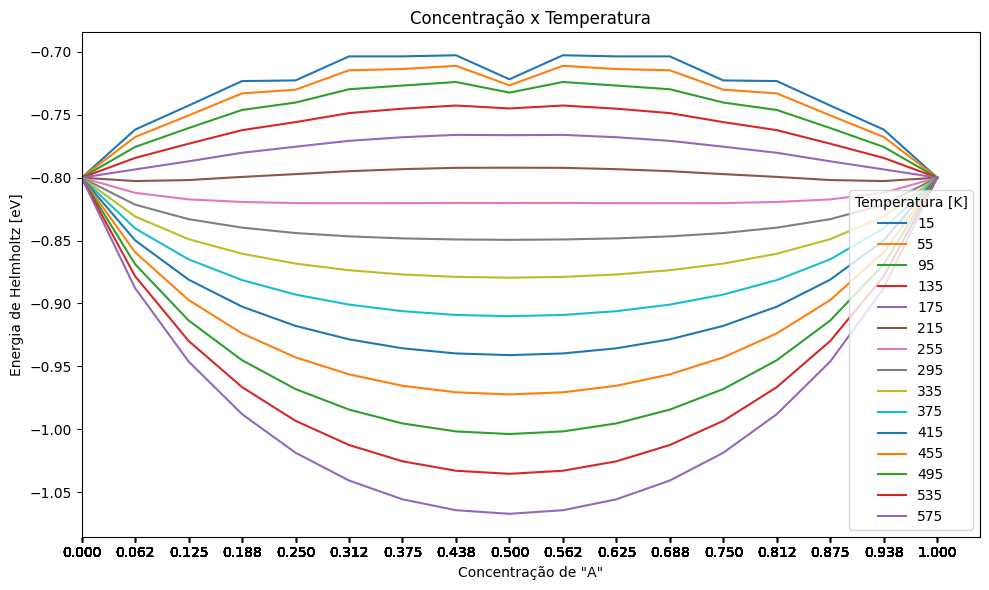

In [15]:
plot_helmholtz(ensemble_canonico, num_particles_discrete=False,img_name = "canonical_ensemble")

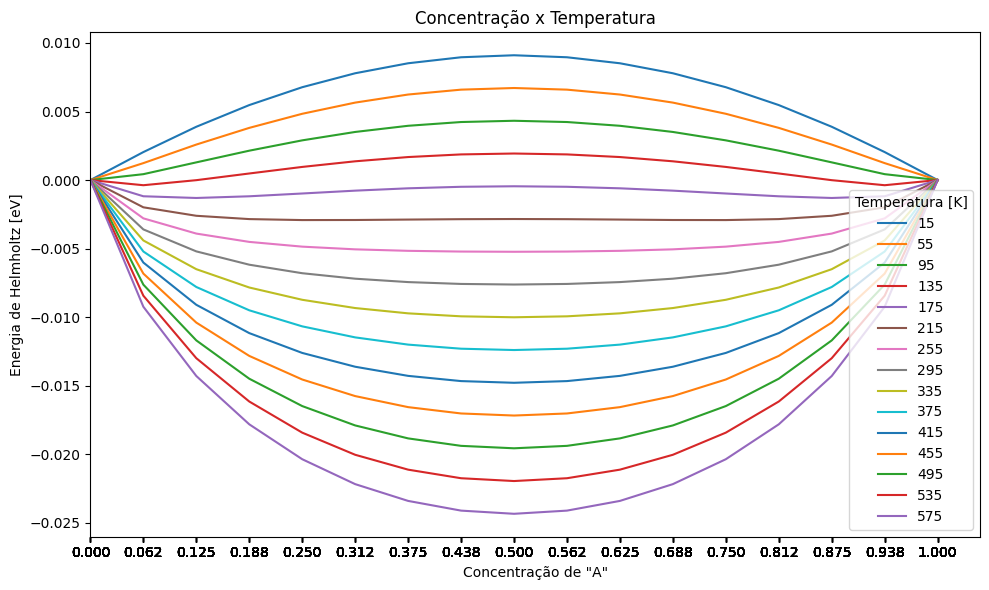

In [16]:
plot_helmholtz(mean_field, num_particles_discrete=False,img_name = "mean_field")

### Playground

In [17]:
import matplotlib.colors as mcolors

# Example list of temperatures
temperatures = [20, 25, 30, 35, 40]

# Generate colors based on a colormap
colormap = plt.cm.viridis  # You can choose any colormap you prefer
norm = mcolors.Normalize(vmin=min(temperatures), vmax=max(temperatures))
colors_rgb = [colormap(norm(temp)) for temp in temperatures]

# Convert RGB colors to hexadecimal strings
colors_hex = [mcolors.rgb2hex(color) for color in colors_rgb]

print(colors_hex)


['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']
